In [1]:
import pandas as pd

In [2]:
users_df = pd.read_csv("Users.csv")
trainers_df = pd.read_excel("Trainers_ Data.xlsx")   
interactions_df = pd.read_csv("All_weeks_Interactions.csv")


In [3]:
# TRAIN on week 3, VALIDATE on week 4 ====
from Model_Training_and_Serving import train_and_validate

best_model, preproc, leaderboard, val_scores = train_and_validate(
    users_df, trainers_df, interactions_df,
    train_week=3,   # labels from week 3, features from ≤ 2
    val_week=4      # labels from week 4, features from ≤ 3
)

/Users/nidhidudeja/Desktop/PhysioMatch /MRDS.py:125: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = g.apply(lambda d: pd.Series({
/Users/nidhidudeja/Desktop/PhysioMatch /MRDS.py:125: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = g.apply(lambda d: pd.Series({


[LightGBM] [Info] Number of positive: 1450, number of negative: 1111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 848
[LightGBM] [Info] Number of data points in the train set: 2561, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.566185 -> initscore=0.266303
[LightGBM] [Info] Start training from score 0.266303


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Validation comparison (train on week 3 → validate on week 4 ) ===
 model   auc_tr   auc_va      p@3    p@5   p@10   ndcg@3   ndcg@5  ndcg@10
logreg 0.605352 0.531437 0.544000 0.4696 0.2828 0.673861 0.745198 0.792766
   xgb 0.999990 0.538232 0.538000 0.4700 0.2828 0.660360 0.739446 0.785845
  lgbm 0.999918 0.541344 0.533333 0.4700 0.2824 0.652689 0.734328 0.780308
    rf 0.999997 0.532182 0.534667 0.4712 0.2830 0.648381 0.729405 0.776123

Selected model: logreg


In [4]:
print(leaderboard)
leaderboard.to_csv("leaderboard.csv", index=False)

    model    auc_tr    auc_va       p@3     p@5    p@10    ndcg@3    ndcg@5  \
0  logreg  0.605352  0.531437  0.544000  0.4696  0.2828  0.673861  0.745198   
3     xgb  0.999990  0.538232  0.538000  0.4700  0.2828  0.660360  0.739446   
2    lgbm  0.999918  0.541344  0.533333  0.4700  0.2824  0.652689  0.734328   
1      rf  0.999997  0.532182  0.534667  0.4712  0.2830  0.648381  0.729405   

    ndcg@10  
0  0.792766  
3  0.785845  
2  0.780308  
1  0.776123  


In [5]:
# Refit the best model on all available data
from Model_Training_and_Serving import refit_on_two_weeks

winner_name = leaderboard.iloc[0]["model"]
final_model, final_preproc = refit_on_two_weeks(
    users_df, trainers_df, interactions_df,
    winner_name=winner_name,
    train_week=3, val_week=4
)

/Users/nidhidudeja/Desktop/PhysioMatch /MRDS.py:125: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = g.apply(lambda d: pd.Series({
/Users/nidhidudeja/Desktop/PhysioMatch /MRDS.py:125: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = g.apply(lambda d: pd.Series({


In [6]:
from Model_Training_and_Serving import serve_topk
from MRDS import build_candidates_time_aware  # to enrich recs with goal_match, etc.

# Build + score all user×trainer candidates for serve_week=5
topk_df = serve_topk(
    users_df, trainers_df, interactions_df,
    preproc_fitted=final_preproc, model_fitted=final_model,
    serve_week=5, topk=5
)
print(topk_df.head())

# Enrich with trainer + user context for readability
Xserve_raw = build_candidates_time_aware(
    users_df, trainers_df, interactions_df, serve_week=5
)

pretty = (topk_df
          .merge(Xserve_raw[["user_id","trainer_id","goal_match"]], on=["user_id","trainer_id"], how="left")
          .merge(trainers_df, on="trainer_id", how="left")
          .merge(users_df[["user_id","goal","fitness_level","age","gender"]], on="user_id", how="left"))

# Choose columns that exist in your trainers_df
cols = [c for c in ["user_id","goal","fitness_level",
                    "trainer_id","specialities","years_experience","athlete_rating",
                    "goal_match","score"] if c in pretty.columns]
pretty = pretty[cols].sort_values(["user_id","score"], ascending=[True, False])

print(pretty.head(20))
pretty.to_csv("recommendations_top5_per_user.csv", index=False)


/Users/nidhidudeja/Desktop/PhysioMatch /MRDS.py:125: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = g.apply(lambda d: pd.Series({


   user_id  trainer_id     score
0        1         366  0.981996
1        1         964  0.929640
2        1         381  0.876766
3        1         299  0.873046
4        1         485  0.872839


/Users/nidhidudeja/Desktop/PhysioMatch /MRDS.py:125: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = g.apply(lambda d: pd.Series({


    user_id             goal fitness_level  trainer_id  \
0         1      weight_loss      advanced         366   
1         1      weight_loss      advanced         964   
2         1      weight_loss      advanced         381   
3         1      weight_loss      advanced         299   
4         1      weight_loss      advanced         485   
5         2      muscle_gain      beginner         377   
6         2      muscle_gain      beginner         998   
7         2      muscle_gain      beginner         689   
8         2      muscle_gain      beginner         166   
9         2      muscle_gain      beginner         632   
10        3  general_fitness  intermediate         377   
11        3  general_fitness  intermediate         998   
12        3  general_fitness  intermediate         689   
13        3  general_fitness  intermediate         166   
14        3  general_fitness  intermediate         632   
15        4      weight_loss      beginner         381   
16        4   

In [7]:
#Are we aligning with user goals?
share_goal_match = (pretty.groupby("user_id")["goal_match"].mean()
                    .rename("pct_top5_goal_matched")).reset_index()
print(share_goal_match.head())
print("Mean % of top-5 with goal match:", share_goal_match["pct_top5_goal_matched"].mean())


   user_id  pct_top5_goal_matched
0        1                    1.0
1        2                    0.0
2        3                    0.0
3        4                    1.0
4        5                    0.0
Mean % of top-5 with goal match: 0.616


In [8]:
#Are the top picks reasonably high quality (by trainer rating/experience)?
agg = (pretty.groupby("user_id")
       .agg(avg_top5_rating=("athlete_rating","mean"),
            avg_top5_exp=("years_experience","mean"))
       .reset_index())
print(agg.head())


   user_id  avg_top5_rating  avg_top5_exp
0        1             3.88          18.2
1        2             4.12          21.0
2        3             4.12          21.0
3        4             3.60          21.0
4        5             4.16          20.4


In [80]:
#See a specific user’s list (with reasons)
def show_user(pretty_df, user_id):
    df = pretty_df[pretty_df["user_id"] == user_id]
    print(df.to_string(index=False))

some_user = pretty["user_id"].iloc[10]
show_user(pretty, some_user)

 user_id            goal fitness_level  trainer_id                                   specialities  years_experience  athlete_rating  goal_match    score
       3 general_fitness  intermediate         377                  Bodybuilding, Sports-Specific                19             3.6           0 0.509540
       3 general_fitness  intermediate         998    Muscle Building, Bodybuilding, Powerlifting                22             4.7           0 0.502086
       3 general_fitness  intermediate         689                   Weight Loss, Sports-Specific                18             4.3           0 0.497497
       3 general_fitness  intermediate         166 Powerlifting, Elderly Fitness, Muscle Building                22             4.9           0 0.496087
       3 general_fitness  intermediate         632                          Sports-Specific, Yoga                24             3.1           0 0.495888


/Users/nidhidudeja/Desktop/PhysioMatch /MRDS.py:125: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = g.apply(lambda d: pd.Series({


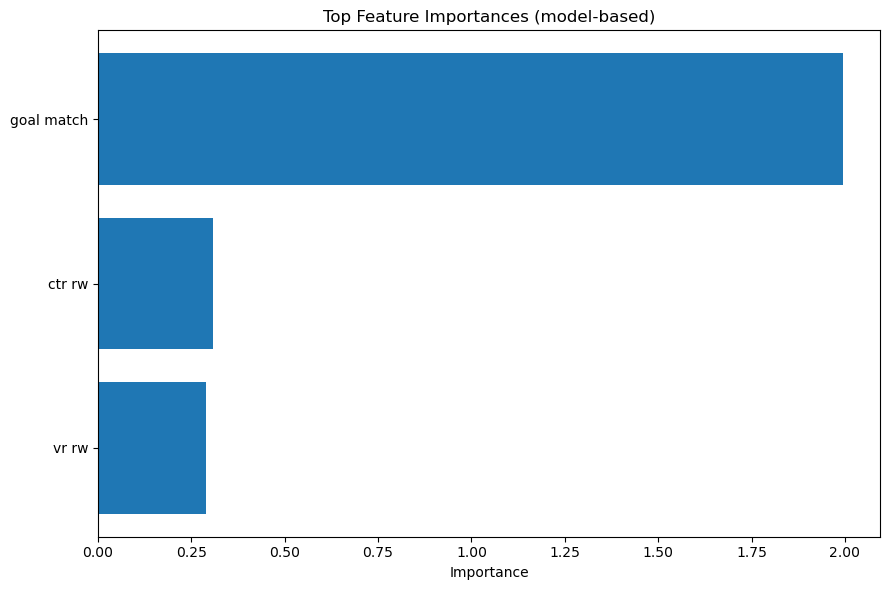

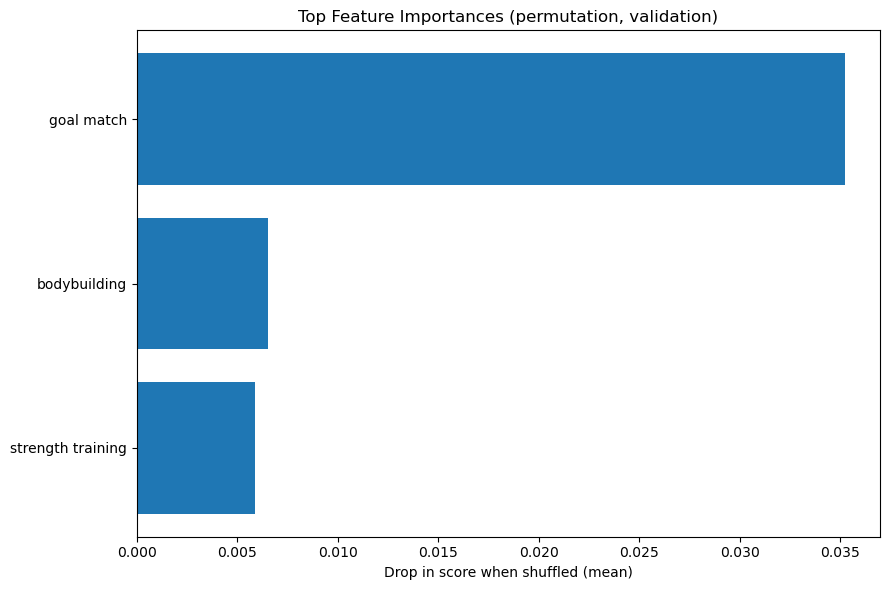

,feature,importance
0,rates__goal_match,1.994230
1,rates__ctr_rw,0.307135
2,rates__vr_rw,0.289172
3,rates__lr_rw,0.274058
4,sp__sp__functional training,0.261197
5,sp__sp__prenatal fitness,0.236989
6,sp__sp__pilates,0.234539
7,counts__vv_rw,0.204452
8,sp__sp__hiit,0.190142
9,cat__goal_flexibility,0.176469


,feature,importance,std
0,rates__goal_match,0.035213,0.002999
1,sp__sp__bodybuilding,0.006519,0.002701
2,sp__sp__strength training,0.005877,0.001868
3,robust__years_experience,0.004000,0.004211
4,sp__sp__rehabilitation,0.002519,0.001542
5,cat__gender_female,0.002074,0.002125
6,small__age,0.001778,0.001556
7,cat__goal_general_fitness,0.001679,0.000784
8,sp__sp__flexibility,0.001284,0.000942
9,robust__workout_recommendations,0.001037,0.001842


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from MRDS import build_time_aware_dataset

# --- A) rebuild validation features (so importance uses the same distribution) ---
VAL_WEEK = 4  # <-- keep consistent with your validation
Xva_raw, yva, _ = build_time_aware_dataset(users_df, trainers_df, interactions_df, target_week=VAL_WEEK)

# --- B) get transformed feature names from your fitted preprocessor ---
def get_feature_names(preproc, X_raw: pd.DataFrame) -> list[str]:
    ct = preproc.named_steps["pre"]  # ColumnTransformer
    try:
        return list(ct.get_feature_names_out(input_features=X_raw.columns))
    except Exception:
        # simple fallback
        names = []
        for name, trans, cols in ct.transformers_:
            if name == "remainder" or trans == "drop":
                continue
            if hasattr(trans, "get_feature_names_out"):
                sub = trans.get_feature_names_out(cols)
            else:
                sub = np.array(cols, dtype=str)
            names.extend([f"{name}__{c}" for c in sub])
        return names

feat_names = get_feature_names(preproc, Xva_raw)

# --- C) model-based importance (fast) ---
def model_importance(model, feature_names: list[str]) -> pd.DataFrame:
    if hasattr(model, "coef_"):  # LogisticRegression
        imp = np.abs(model.coef_.ravel())
    elif hasattr(model, "feature_importances_"):  # RF / LGBM / XGB
        imp = model.feature_importances_
    else:
        raise ValueError("Model type not supported for direct importance. Use permutation importance.")
    df = pd.DataFrame({"feature": feature_names, "importance": imp})
    return df.sort_values("importance", ascending=False).reset_index(drop=True)

imp_model = model_importance(best_model, feat_names)

# tidy labels a bit for the plot
def pretty_label(s: str) -> str:
    for p in ("counts__", "rates__", "small__", "robust__", "sp__", "cat__"):
        s = s.replace(p, "")
    return s.replace("_", " ")

TOPN = 3
plot_df = imp_model.head(TOPN).copy()
plot_df["pretty"] = plot_df["feature"].map(pretty_label)

plt.figure(figsize=(9, 6))
plt.barh(plot_df["pretty"][::-1], plot_df["importance"][::-1])
plt.xlabel("Importance")
plt.title("Top Feature Importances (model-based)")
plt.tight_layout()
plt.show()

# --- D) permutation importance on validation (model-agnostic) ---
Xva = preproc.transform(Xva_raw)
perm = permutation_importance(best_model, Xva, yva, n_repeats=8, random_state=42, n_jobs=-1)

imp_perm = (pd.DataFrame({
    "feature": feat_names,
    "importance": perm.importances_mean,
    "std": perm.importances_std
})
.sort_values("importance", ascending=False)
.reset_index(drop=True))

p20 = imp_perm.head(TOPN).copy()
p20["pretty"] = p20["feature"].map(pretty_label)

plt.figure(figsize=(9, 6))
plt.barh(p20["pretty"][::-1], p20["importance"][::-1])
plt.xlabel("Drop in score when shuffled (mean)")
plt.title("Top Feature Importances (permutation, validation)")
plt.tight_layout()
plt.show()

# (optional) show both tables
display(imp_model.head(30))
display(imp_perm.head(30))

